# Shapley Value Attribution for Sequential (LSTM) Models

This document presents a rigorous treatment of Shapley value attributions applied to Long Short-Term Memory (LSTM) neural networks. We elucidate the theoretical foundations, derive the formal definition for sequence data, describe unbiased Monte Carlo estimation of ground-truth values, and explain the adaptation of the SHAP DeepExplainer. Finally, we outline a methodology for comparative visualization and discuss the implications of interpretability in sequential models.

## 1. Introduction
Interpreting the contributions of individual inputs to a model’s prediction is critical for transparency in machine learning. While Shapley values are well established for static, tabular data, sequence models such as LSTMs pose a conceptual extension: each input element appears in temporal context. We treat each time–feature pair as an independent “player” in the Shapley game, enabling fair attribution across the entire sequence.

## 2. Formal Definition for Sequence Attributions

Let:

- $T$ denote the length of the input sequence  
- $F$ the feature dimension at each time step  
- $N_{\text{seq}} = \{(t, i) : t = 1, \dots, T;\ i = 1, \dots, F \}$ the set of all time–feature pairs  
- $x \in \mathbb{R}^{T \times F}$ a specific input sequence  
- $f : \mathbb{R}^{T \times F} \to \mathbb{R}$ the model’s scalar output  
- $b \in \mathbb{R}^{T \times F}$ the baseline sequence (e.g., empirical mean over reference set)

For any coalition $S \subseteq N_{\text{seq}}$, define the masked sequence $x_S$ by:

$$
x_S[t, i] =
\begin{cases}
x[t, i], & \text{if } (t, i) \in S \\
b[t, i], & \text{otherwise}
\end{cases}
$$

The Shapley value for the cell $(t, i)$ is:

$$
\phi_{t, i} =
\sum_{S \subseteq N_{\text{seq}} \setminus \{(t, i)\}}
\frac{|S|! \cdot (|N_{\text{seq}}| - |S| - 1)!}{|N_{\text{seq}}|!}
\left[ f(x_{S \cup \{(t, i)\}}) - f(x_S) \right]
$$

This ensures fair attribution across all possible input combinations and satisfies the axioms of efficiency, symmetry, nullity, and additivity.

## 3. Unbiased Monte Carlo Estimation

The exact summation spans $2^{T \cdot F}$ coalitions, which becomes intractable. We instead use a Monte Carlo estimator:

1. For each $(t, i)$ and $m = 1, \dots, M$, sample $S_m \subseteq N_{\text{seq}} \setminus \{(t, i)\}$ by including each other cell independently with probability 0.5  
2. Compute marginal contributions:  
   $$
   d_m = f(x_{S_m \cup \{(t, i)\}}) - f(x_{S_m})
   $$
3. Estimate:  
   $$
   \phi_{t, i}^{\text{MC}} \approx \frac{1}{M} \sum_{m=1}^M d_m
   $$

By the law of large numbers, $\phi_{t, i}^{\text{MC}} \to \phi_{t, i}$ as $M \to \infty$.

## 4. SHAP DeepExplainer Adaptation

SHAP DeepExplainer uses a background set $X_b = \{x'^{(1)}, \dots, x'^{(K)}\}$ to estimate:

$$
\mathbb{E}_{x' \sim X_b}[f(x')] \approx \frac{1}{K} \sum_{k=1}^K f(x'^{(k)})
$$

Then it computes attributions $\psi_{t, i}(x)$ satisfying:

$$
f(x) = \mathbb{E}[f(x')] + \sum_{t=1}^T \sum_{i=1}^F \psi_{t, i}(x)
$$

Nonlinear recurrent operations are linearized via Taylor expansion around each background sample, and backpropagation aggregates the contributions. For LSTM internals, `check_additivity=False` can be set to disable exact-sum checking if the model structure leads to slight mismatches.

## 5. Comparative Visualization Method

To compare $\phi^{\text{MC}}$ and $\psi$, we reshape both into $T \times F$ matrices and visualize using 3D bar charts:

- **Axes:** time index $t$, feature index $i$, attribution magnitude  
- **Left Plot:** Monte Carlo estimate $\phi_{t, i}^{\text{MC}}$  
- **Right Plot:** SHAP DeepExplainer attribution $\psi_{t, i}$

A close match between surfaces indicates high fidelity of the approximation.

## 6. Discussion and Conclusion

This exposition extends Shapley values to sequential models by treating time–feature positions as individual contributors. Monte Carlo sampling yields unbiased attributions, while DeepExplainer offers efficient, differentiable approximations. Visualization of attribution surfaces enables interpretation of temporal dynamics and helps validate explainer reliability.


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Explainer base value (E[f(x)]): -0.9881
Model output on x_test:      -1.8012
Sum of SHAP φ’s:             -1.4145  (≈ model(x) - base_value)


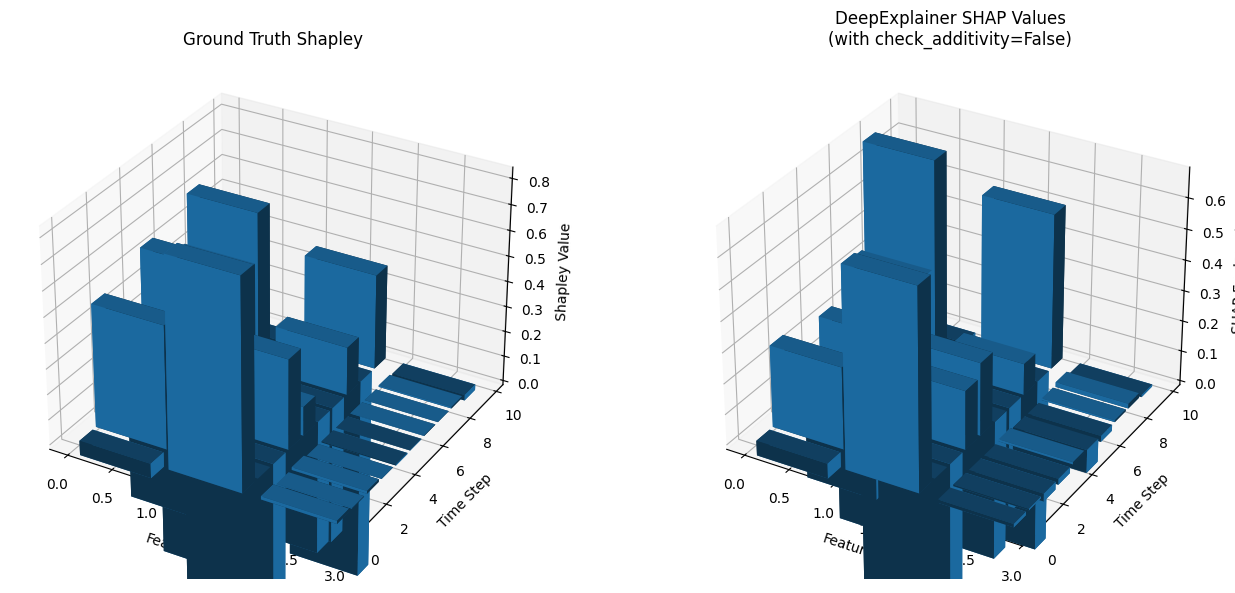

In [1]:
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Define a simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch, seq_len, features]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use last time step
        return self.fc(out)

# 2. Create synthetic sequential data
seq_len    = 10
n_features = 3
n_samples  = 200

X = np.random.randn(n_samples, seq_len, n_features)
# Target is sum over time of feature 0 minus feature 1 (for demonstration)
y = X[:, :, 0].sum(axis=1) - X[:, :, 1].sum(axis=1)

# 3. Train the model quickly
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = LSTMModel(n_features, hidden_dim=8, output_dim=1).to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn  = nn.MSELoss()

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    preds = model(X_tensor)
    loss  = loss_fn(preds, y_tensor)
    loss.backward()
    optimizer.step()

# 4. Select a single test instance and define baseline
x_test     = X[0]
x_baseline = X.mean(axis=0)  # baseline: the average sequence

# 5. Ground-truth Shapley via Monte Carlo
def compute_shapley_gt(model, x, baseline, nsamples=200):
    T, F = x.shape
    shap_vals = np.zeros((T, F))
    model.eval()
    with torch.no_grad():
        for t in range(T):
            for f in range(F):
                contribs = []
                for _ in range(nsamples):
                    # random coalition mask
                    mask = np.random.rand(T, F) < 0.5
                    mask_with    = mask.copy(); mask_with[t, f] = True
                    mask_without = mask.copy(); mask_without[t, f] = False

                    def apply_mask(m):
                        x_mask = baseline.copy()
                        x_mask[m] = x[m]
                        inp = torch.tensor(x_mask[None], dtype=torch.float32).to(device)
                        return model(inp).cpu().numpy().squeeze()

                    y0 = apply_mask(mask_without)
                    y1 = apply_mask(mask_with)
                    contribs.append(y1 - y0)
                shap_vals[t, f] = np.mean(contribs)
    return shap_vals

shap_gt = compute_shapley_gt(model, x_test, x_baseline)

# 6. SHAP package explanation (with additivity check disabled)
background = torch.tensor(X[:50], dtype=torch.float32).to(device)
explainer  = shap.DeepExplainer(model, background)

# disable the strict additivity check
shap_values_all = explainer.shap_values(
    torch.tensor(x_test[None], dtype=torch.float32).to(device),
    check_additivity=False
)

# shap_values_all is a list (one array per model output dimension)
shap_model = shap_values_all[0].reshape(seq_len, n_features)

# base (expected) value from the explainer
base_value = explainer.expected_value[0]
print(f"Explainer base value (E[f(x)]): {base_value:.4f}")
print(f"Model output on x_test:      {model(torch.tensor(x_test[None], dtype=torch.float32).to(device)).item():.4f}")
print(f"Sum of SHAP φ’s:             {shap_model.sum():.4f}  (≈ model(x) - base_value)")

# 7. Plot comparison in 3D bar plots
fig = plt.figure(figsize=(14, 6))

# Ground truth
ax1 = fig.add_subplot(121, projection='3d')
_x   = np.arange(n_features)
_y   = np.arange(seq_len)
xx, yy = np.meshgrid(_x, _y)
xpos = xx.flatten()
ypos = yy.flatten()
zpos = np.zeros_like(xpos)
dx = dy = 0.8
dz_gt = shap_gt.flatten()

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz_gt)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Time Step')
ax1.set_zlabel('Shapley Value')
ax1.set_title('Ground Truth Shapley')

# SHAP package
ax2 = fig.add_subplot(122, projection='3d')
dz_mod = shap_model.flatten()

ax2.bar3d(xpos, ypos, zpos, dx, dy, dz_mod)
ax2.set_xlabel('Feature')
ax2.set_ylabel('Time Step')
ax2.set_zlabel('SHAP Explanation')
ax2.set_title('DeepExplainer SHAP Values\n(with check_additivity=False)')

plt.tight_layout()
plt.show()
